# 从NCBI中获取序列和基因标注信息

In [26]:
import tqdm
import pandas as pd
import numpy as np
from Bio import Entrez, SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import re

tlp = "C:\\Users\\jinya\\Desktop\\bio\\data\\fast"
adf = pd.read_csv(f"{tlp}\\Aquareovirus_fast.csv")
odf = pd.read_csv(f"{tlp}\\Orthoreovirus_fast.csv")
df = pd.concat([adf,odf])
df = df[["Accession","Species","Organism_Name","Host","Protein","Length"]]
# adf[["Accession","Species","Organism_Name","Host","Protein","Length"]]
# odf[["Accession","Species","Organism_Name","Host","Protein","Length"]]

def fetch_protein_from_ncbi(protein_id):
    try:
        Entrez.email = "John@hotmail.com"
        handle = Entrez.efetch(db="protein", id=protein_id, rettype="fasta")
        record = SeqIO.read(handle, "fasta")
        handle.close()
        return str(record.seq) if record else ""
    except:
        return ""
    

def calculate_molecular_weight(sequence):
    amino_acid_weights = {
      'A': 89.09, 'C': 121.16, 'D': 115.09, 'E': 129.12,
      'F': 165.19, 'G': 75.07, 'H': 155.16, 'I': 131.17,
      'K': 128.17, 'L': 131.17, 'M': 149.21, 'N': 114.11,
      'P': 115.13, 'Q': 128.14, 'R': 174.20, 'S': 105.09,
      'T': 119.12, 'V': 117.15, 'W': 204.23, 'Y': 181.19
    }
    molecular_weight = 0
    for residue in sequence:
        if residue in amino_acid_weights:
            molecular_weight += amino_acid_weights[residue]
        else:
            pass
    molecular_weight -= 18*(len(sequence)-1)
    return molecular_weight

def normalize(name):
    for pid in ("10","13","14","15","16","22"):
        if pid in name:
            return f"P{pid}"
    return "UNK"


tqdm.tqdm.pandas(desc="get feature in input_data")
df["seq"]= df["Accession"].progress_apply(lambda x: fetch_protein_from_ncbi(x))
df["weight"] = df["seq"].apply(calculate_molecular_weight)
df["Protein_Name"] = df["Protein"].apply(normalize)
df["Famliy"] = df["Species"].apply(lambda x: "Orthoreovirus" if "orth" in x.lower() else  "Aquareovirus")
df.to_csv(f"{tlp}\\fast.csv",index=False)
lst = []
for index, row in  df.iterrows():
    record = SeqRecord(Seq(row["seq"]), id=row["Species"]+"_"+row["Accession"], description="")
    lst.append(record)
SeqIO.write(lst, f"{tlp}\\fast.fasta", "fasta")

get feature in input_data: 100%|██████████| 626/626 [19:10<00:00,  1.84s/it]


,Accession,Species,Organism_Name,Host,Protein,Length,seq
0,YP_009507758,Aquareovirus scophthalmi,Scophthalmus maximus reovirus,Scophthalmus maximus,NS22,198,MGNTISSTFQYTVLQIDRSCCIKTSLTATSEATSWAIPPLAICCCC...
1,YP_009351842,Fall chinook aquareovirus,Fall chinook aquareovirus,Oncorhynchus tshawytscha,NS22,207,MPCGDTIATTFQYTVLQVDRSCCISTSVTATSEATSWALPPILACC...
2,YP_001837100,Aquareovirus graminis,American grass carp reovirus,Ctenopharyngodon idella,NS16,141,MPCQDTVSLSIQHTHVIIQNSCCTTVSTSASTSATAYGLGCLALGC...
3,QBC40936,Marbled eel reovirus,Marbled eel reovirus,Anguilla marmorata,NS22,164,MPCNDAIASTTQVTITYISHSCCISTSSSAAAEASLPCIGLTTGGC...
4,AZM69452,Aquareovirus C,Grass carp reovirus,Ctenopharyngodon idella,NS16,146,MPCQDTVSLSIQHTSVYVQHSCCVSTTTSASTSATALGLGCLACGI...
...,...,...,...,...,...,...,...
611,AAL01374,Baboon orthoreovirus,Baboon orthoreovirus,NaN,p16,141,MMEETQMEVSTFEWPKSLDESLQVLCNELKGKTEWQDDMEDWMPYW...
612,AGX27781,Avian orthoreovirus,Duck reovirus,Anatidae,protein 10,97,MADGACNHATSIFGAVYCQISQNIAHGNIDSYTSWASYLPPILGGG...
613,AGH25582,Avian orthoreovirus,Duck reovirus NP03/CHN/2009,Cairina moschata,protein 10,97,MADGACNHATSIFGAVYCQISQNIAHGNIDSYTSWTSYLPPILGGG...
614,YP_004769555,Orthoreovirus papionis,Baboon orthoreovirus,NaN,membrane fusion protein p15,140,MGQRHSIVQPPAPPPNAFVEIVSSSTGIIIAVGIFAFIFSFLYKLL...


# 数据预处理

In [17]:
import itertools
import pandas as pd
from Bio import Entrez, SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

tlp = "C:\\Users\\jinya\\Desktop\\bio\\data\\fast"

df = pd.read_csv(f"{tlp}\\fast.csv")
df = df[df.Length>75]
d,dc= {},{}
for index, row in  df.iterrows():
    pn = row["Protein_Name"]
    dc[pn] = dc.get(pn,0)+1
    record = SeqRecord(Seq(row["seq"]), id=row["Species"]+"_"+row["Protein_Name"]+"_"+ str(dc[pn]), description="")
    lst = d.get(pn,list())
    lst.append(record)
    d[pn] = lst
for k, v in d.items():
    SeqIO.write(v, f"{tlp}\\fast_{k}.fasta", "fasta")
tlst = list(itertools.chain(*d.values()))
SeqIO.write(tlst, f"{tlp}\\fast.fasta", "fasta")

621

# 数据分布统计

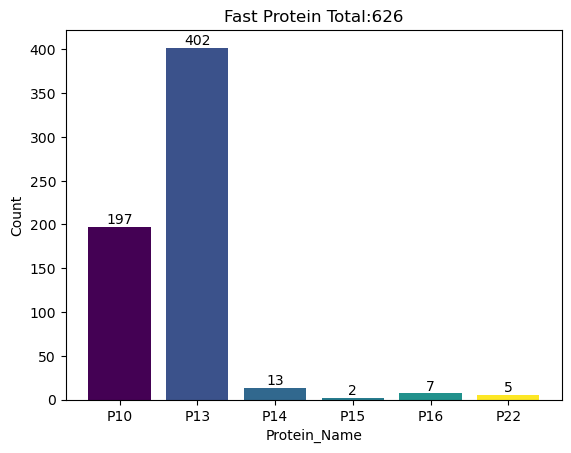

In [79]:
import matplotlib.pyplot as plt
import numpy as np
pdf=df["Protein_Name"].value_counts().to_frame().reset_index().sort_values("Protein_Name")
pdf["index"] = pdf["Protein_Name"].apply(lambda x : int(x[-2:]))
total = pdf["count"].sum()
# 绘图
plt.bar(pdf["Protein_Name"], pdf["count"],color=plt.cm.viridis((pdf["index"].values-10)/12))
for i in range(pdf.shape[0]):
    plt.text(pdf["Protein_Name"][i], pdf["count"][i] + 0.1, str(pdf["count"][i]), ha='center', va='bottom')
plt.xlabel("Protein_Name")
plt.ylabel('Count')
plt.title(f'Fast Protein Total:{total}')
plt.show()

In [41]:
import pandas as pd
from Bio import Entrez, SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

def extract_tm(x):
    align = x.seq_align
    if x.PName=="P10":
        b,e = 40,62
    else:
        b,e = 34,56
    tm = align[b:e].replace("-","")
    start = len(align[:b].replace("-",""))
    end = start+len(tm)
    return tm,start,end


tlp = "C:\\Users\\jinya\\Desktop\\bio\\data\\fast"
df = pd.read_csv(f"{tlp}\\fast_human.csv")
df["seq"] = df.seq_align.apply(lambda x:x.replace("-",""))
p10_lst, plst = [],[]
for index, row in  df.iterrows():
    if row.PName == "P10":
        p10_lst.append(SeqRecord(Seq(row["seq"]), id=row["name"], description="length"))
    else:
        plst.append(SeqRecord(Seq(row["seq"]), id=row["name"], description="length"))
# SeqIO.write(p10_lst, f"{tlp}\\p10_human.fasta", "fasta")
# SeqIO.write(plst, f"{tlp}\\pp_human.fasta", "fasta")
SeqIO.write(plst+p10_lst, f"{tlp}\\fast_human.fasta", "fasta")
df[["TM","TM_start","TM_end"]] = df.apply(extract_tm,axis=1, result_type="expand")
    

10

In [42]:
from Bio import SeqIO
from Bio import pairwise2

def align_var(s1,s2):
    alignments = pairwise2.align.globalxx(s1.seq, s2.seq)
    for align in alignments:
        start,end,idx = -1, -1,0
        for i,ch in enumerate(align.seqA):
            if idx==s1.TM_start:
                start=i
            elif idx==s1.TM_end:
                end =i
            if ch!="-":
                idx+=1
            
        start2 = len(align.seqB[:start].replace("-",""))
        end2 = len(align.seqB[:end].replace("-",""))
        break
    return s2.TM_start-start2, s2.TM_end-end2

for idx in range(5):
    ref = df.iloc[idx]
    for i,x in df[:5].iterrows():
        pass
#         print(idx,i,align_var(ref,x))

for idx in range(5):
    ref = df.iloc[idx+5]
    for i,x in df[5:].iterrows():
        pass
#         print(idx+5,i,align_var(ref,x))
